In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device='cpu'

In [3]:
image_paths = './Data/*/*'
image_paths = glob(image_paths)

In [4]:
len(image_paths)

1944

In [5]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[2]
    image = image_path.split(os.path.sep)[3]
    labels.append(label)
    images.append(image)

In [6]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 4)))
pred2label = dict(zip(range(0, 4), np.unique(labels)))
n_classes = len(np.unique(labels))

In [7]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [8]:
class EfficientNetB3(ClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = timm.create_model('efficientnet_b3', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, n_classes))
        
        
    def forward(self, batch):
        batch = batch.to(device)
        return F.softmax(self.network(batch))

model = EfficientNetB3()

In [9]:
model = model.to(device)

In [ ]:
model.load_state_dict(torch.load('eye-disease.pth', map_location=torch.device('cpu')))
model.eval()

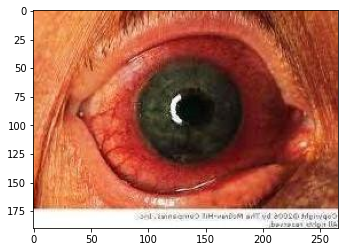

In [11]:
image = cv2.imread('./Data/Uveitis/102.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [12]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((300, 300))
])

image = test_transforms(image)
image = torch.reshape(image, (1, 3, 300, 300))

In [13]:
model.eval()
pred2label[np.argmax(model(image).cpu().detach().numpy())]

/var/folders/37/cr55t1yj4_q7mn_gwsg1qk640000gn/T/ipykernel_44816/139550959.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.network(batch))


'Uveitis'